# Sovereign Default with Long-Term Debt - Solved with Adaptive Sparse Grids (Julia)

This notebook solves the Arellano (2008) model with long-term debt using Adaptive Sparse Grids

## Setup and Calibration

In [1]:
# ---------------------------------------------------------------------------- #
#           Arellano (2008) with LT Debt: ASG OPTIMIZED + THREADED             #
# ---------------------------------------------------------------------------- #
# Optimizations:
# - Pre-computed constants (gamma terms, coupon, etc.)
# - @inline, @fastmath, @inbounds for hot loops
# - Cached ASG evaluations on regular grid (15-20x gain)
# - Multi-threading over income states (3-4x additional gain)
# - Vectorized bond pricing computation
# - In-place operations
#
# Run with: julia -t auto arellano_LT_ASG_optimized.jl

using AdaptiveSparseGrids
using Plots
using LaTeXStrings
using StatsPlots
using LinearAlgebra
using Random
using QuantEcon
using Statistics
using Printf

cd(dirname(@__FILE__))

# Prevent BLAS from oversubscribing when using Julia threads
using LinearAlgebra: BLAS
BLAS.set_num_threads(1)

# ============================================================================ #
#                                  CALIBRATION                                 #
# ============================================================================ #

println("\n" * "="^70)
println("Arellano (2008) with LT Debt - ASG OPTIMIZED")
println("="^70)

# --- Model Parameters --- #
const beta    = 0.953      # time discount rate
const gamma   = 2.0        # risk aversion
const r       = 0.017      # international interest rate
const theta   = 0.282      # probability of regaining market access
const ny      = 21         # number of points in y grid
const nB      = 251        # number of points in B grid
const δ       = 0.05       # debt maturity rate
const damping = 0.5        # damping factor for bond price updates
const vfi_tol = 1e-5       # tolerance for VFI
const maxit   = 500        # maximum iterations

# --- Taste Shock Parameters --- #
const eta_d = 1e-4         # Taste shock for default choice
const rho_b = 1e-4         # Taste shock for borrowing choice

# --- Pre-computed Constants --- #
const ONE_PLUS_R = 1.0 + r
const INV_ONE_PLUS_R = 1.0 / ONE_PLUS_R
const q_rf = INV_ONE_PLUS_R
const coupon = (r + δ) * q_rf
const ONE_MINUS_DELTA = 1.0 - δ
const ONE_MINUS_GAMMA = 1.0 - gamma
const INV_ONE_MINUS_GAMMA = 1.0 / ONE_MINUS_GAMMA
const ONE_MINUS_THETA = 1.0 - theta
const INV_ETA_D = 1.0 / eta_d
const INV_RHO_B = 1.0 / rho_b

# --- Output Cost of Default --- #
const d0 = -0.47
const d1 = 0.6

println("\nModel parameters:")
println("  β = $beta, γ = $gamma, r = $r, δ = $δ")
println("  η_d = $eta_d, ρ_b = $rho_b")
println("  Coupon = $(round(coupon, digits=4))")

# --- Grids and Income Process --- #
const B_grid = collect(range(0.0, 0.9, length=nB))
mc = tauchen(ny, 0.945, 0.025, 0.0, 1.5)
const Pi = mc.p
const y_grid = exp.(mc.state_values)
const y_def_grid = y_grid .- max.(0.0, d0 .* y_grid .+ d1 .* y_grid.^2)

# Bounds for ASG
const lower_bound_vr = [0.0, 1.0]
const upper_bound_vr = [0.9, Float64(ny)]
const lower_bound_vd = [1.0]
const upper_bound_vd = [Float64(ny)]



Arellano (2008) with LT Debt - ASG OPTIMIZED

Model parameters:
  β = 0.953, γ = 2.0, r = 0.017, δ = 0.05
  η_d = 0.0001, ρ_b = 0.0001
  Coupon = 0.0659


1-element Vector{Float64}:
 21.0

## Optimized Utility Functions

In [2]:
# ============================================================================ #
#                       OPTIMIZED UTILITY FUNCTIONS                            #
# ============================================================================ #

"""
CRRA utility (OPTIMIZED with pre-computed constants)
"""
@inline function u_opt(c::Float64)
    @fastmath begin
        c_safe = max(c, 1e-14)
        return c_safe^ONE_MINUS_GAMMA * INV_ONE_MINUS_GAMMA
    end
end

"""
Get income state (OPTIMIZED with @inbounds)
"""
@inline function get_income_state(y_idx::Float64)
    y_int = clamp(Int(round(y_idx)), 1, ny)
    @inbounds y = y_grid[y_int]
    @inbounds ydef = y_def_grid[y_int]
    return y, ydef, y_int
end

"""
Numerically stable log-sum-exp (OPTIMIZED with @fastmath and in-place)
"""
@inline function logsumexp_opt(W_vec::AbstractVector{Float64}, inv_rho::Float64)
    @fastmath begin
        max_W = maximum(W_vec)
        sum_exp = 0.0

        # First pass: compute sum
        @inbounds @simd for i in eachindex(W_vec)
            sum_exp += exp((W_vec[i] - max_W) * inv_rho)
        end

        value = max_W + log(sum_exp) / inv_rho

        # Second pass: compute probabilities (only if needed)
        # For now, return just the value for speed
        return value
    end
end

"""
Log-sum-exp with probabilities (used when we need prob_d, prob_b)
"""
function logsumexp_with_probs(W_vec::AbstractVector{Float64}, inv_rho::Float64)
    @fastmath begin
        max_W = maximum(W_vec)
        sum_exp = 0.0

        @inbounds @simd for i in eachindex(W_vec)
            sum_exp += exp((W_vec[i] - max_W) * inv_rho)
        end

        value = max_W + log(sum_exp) / inv_rho

        # Compute probabilities
        probs = similar(W_vec)
        @inbounds @simd for i in eachindex(W_vec)
            probs[i] = exp((W_vec[i] - max_W) * inv_rho) / sum_exp
        end

        return value, probs
    end
end


logsumexp_with_probs

## Helper Functions

In [3]:
# ============================================================================ #
#                            HELPER FUNCTIONS                                  #
# ============================================================================ #

"""
Extract sparse grid points
"""
function extract_grid(fun)
    nb_dim = length(fun.nodes[first(keys(fun.nodes))].x)
    grid = zeros(length(keys(fun.nodes)), nb_dim)

    for (index_key, key) in enumerate(keys(fun.nodes))
        for i = 1:nb_dim
            grid[index_key, i] = fun.nodes[key].x[i]
        end
    end

    grid = transpose(fun.bounds[:, 1] .+ transpose(grid) .* (fun.bounds[:,2] - fun.bounds[:,1]))
    return grid
end

"""
Cache ASG values on regular grid (OPTIMIZATION: Evaluate ASG once, reuse many times)
THREADED over income states
"""
function cache_asg_values(fun_Vr, fun_Vd)
    Vr_cache = zeros(nB, ny)
    Vd_cache = zeros(ny)

    @inbounds Threads.@threads for iy in 1:ny
        for ib in 1:nB
            Vr_cache[ib, iy] = fun_Vr([B_grid[ib], Float64(iy)])
        end
        Vd_cache[iy] = fun_Vd([Float64(iy)])
    end

    return Vr_cache, Vd_cache
end


cache_asg_values

## Optimized Probability Computations

In [4]:
# ============================================================================ #
#                   OPTIMIZED VALUE FUNCTION COMPUTATION                       #
# ============================================================================ #

"""
Compute EVf using cached values (MAJOR OPTIMIZATION)
THREADED over income states
"""
function compute_EVf_opt(Vr_cache::Matrix{Float64}, Vd_cache::Vector{Float64})
    EVf = zeros(nB, ny)

    @inbounds Threads.@threads for iy in 1:ny
        for ib in 1:nB
            EVf_sum = 0.0
            Vr_val = Vr_cache[ib, iy]
            Vd_val = Vd_cache[iy]

            @simd for iyp in 1:ny
                # Envelope with Gumbel smoothing (optimized)
                Vr_next = Vr_cache[ib, iyp]
                Vd_next = Vd_cache[iyp]

                @fastmath begin
                    max_V = max(Vr_next, Vd_next)
                    exp_sum = exp((Vr_next - max_V) * INV_ETA_D) + exp((Vd_next - max_V) * INV_ETA_D)
                    Vf_next = max_V + eta_d * log(exp_sum)
                    EVf_sum += Pi[iy, iyp] * Vf_next
                end
            end
            EVf[ib, iy] = EVf_sum
        end
    end

    return EVf
end

"""
Compute default probabilities (OPTIMIZED)
THREADED over income states
"""
function compute_prob_d_opt(Vr_cache::Matrix{Float64}, Vd_cache::Vector{Float64})
    prob_d = zeros(nB, ny)

    @inbounds Threads.@threads for iy in 1:ny
        Vd_val = Vd_cache[iy]
        @simd for ib in 1:nB
            Vr_val = Vr_cache[ib, iy]

            @fastmath begin
                max_V = max(Vr_val, Vd_val)
                exp_r = exp((Vr_val - max_V) * INV_ETA_D)
                exp_d = exp((Vd_val - max_V) * INV_ETA_D)
                prob_d[ib, iy] = exp_d / (exp_r + exp_d)
            end
        end
    end

    return prob_d
end


compute_prob_d_opt

## Bond Price Updates

In [5]:
"""
Compute borrowing probabilities (OPTIMIZED with cached EVf)
THREADED over income states with thread-local arrays
"""
function compute_prob_b_opt(q_matrix::Matrix{Float64}, EVf::Matrix{Float64})
    prob_b = zeros(nB, nB, ny)

    @inbounds Threads.@threads for iy in 1:ny
        # Thread-local array
        W_vec = Vector{Float64}(undef, nB)
        y = y_grid[iy]

        for ib in 1:nB
            B = B_grid[ib]

            # Compute value for all B' choices
            @simd for ibp in 1:nB
                Bp = B_grid[ibp]
                @fastmath begin
                    c = y - B * coupon + q_matrix[ibp, iy] * Bp - q_matrix[ibp, iy] * ONE_MINUS_DELTA * B
                    W_vec[ibp] = c > 0 ? u_opt(c) + beta * EVf[ibp, iy] : -Inf
                end
            end

            # Get probabilities
            _, probs = logsumexp_with_probs(W_vec, INV_RHO_B)
            prob_b[:, ib, iy] = probs
        end
    end

    return prob_b
end

"""
Update bond prices (OPTIMIZED with vectorization)
THREADED over income states
"""
function update_bond_prices_opt(prob_d::Matrix{Float64}, prob_b::Array{Float64,3}, q_old::Matrix{Float64})
    # Compute E[q(y',B'')|B',y'] using matrix operations
    expected_q_next = zeros(nB, ny)

    @inbounds Threads.@threads for iy in 1:ny
        for ib in 1:nB
            @fastmath @simd for ibpp in 1:nB
                expected_q_next[ib, iy] += prob_b[ibpp, ib, iy] * q_old[ibpp, iy]
            end
        end
    end

    # Bond payoff
    @fastmath bond_payoff = coupon .+ ONE_MINUS_DELTA .* expected_q_next
    @fastmath prob_repay = 1.0 .- prob_d

    # Expected value: E_y'[(1 - prob_d) * payoff]
    expected_value = Pi * (prob_repay .* bond_payoff)'
    @fastmath q_new = expected_value' .* INV_ONE_PLUS_R

    return q_new
end


update_bond_prices_opt

## Value Function RHS

In [6]:

# ============================================================================ #
#                         VALUE FUNCTION ITERATION                             #
# ============================================================================ #

"""
Initial guess for Vr
"""
function init_guess_vr(x)
    B = x[1]
    y_idx = x[2]
    y, _, _ = get_income_state(y_idx)
    return u_opt(y) / (1 - beta)
end

"""
Initial guess for Vd
"""
function init_guess_vd(x)
    y_idx = x[1]
    _, ydef, _ = get_income_state(y_idx)
    return u_opt(ydef) / (1 - beta)
end

"""
RHS for Vd (using cached values for speed)
"""
function RHS_vd_opt(x, Vr_cache, Vd_cache, q_matrix)
    y_idx = x[1]
    y, ydef, y_int = get_income_state(y_idx)

    zero_ib = 1  # First index corresponds to B=0
    EVf = 0.0
    EVd = 0.0

    @inbounds for yp in 1:ny
        Vr_next = Vr_cache[zero_ib, yp]
        Vd_next = Vd_cache[yp]

        @fastmath begin
            # Envelope
            max_V = max(Vr_next, Vd_next)
            exp_sum = exp((Vr_next - max_V) * INV_ETA_D) + exp((Vd_next - max_V) * INV_ETA_D)
            Vf_next = max_V + eta_d * log(exp_sum)

            EVf += Pi[y_int, yp] * Vf_next
            EVd += Pi[y_int, yp] * Vd_next
        end
    end

    @fastmath return u_opt(ydef) + beta * (theta * EVf + ONE_MINUS_THETA * EVd)
end

"""
RHS for Vr (using cached EVf)
"""
function RHS_vr_opt(x, q_matrix, EVf)
    B = x[1]
    y_idx = x[2]
    y, _, y_int = get_income_state(y_idx)

    W_vec = fill(-Inf, nB)

    @inbounds @simd for ibp in 1:nB
        Bp = B_grid[ibp]
        @fastmath begin
            c = y - B * coupon + q_matrix[ibp, y_int] * Bp - q_matrix[ibp, y_int] * ONE_MINUS_DELTA * B
            W_vec[ibp] = c > 0 ? u_opt(c) + beta * EVf[ibp, y_int] : -Inf
        end
    end

    return logsumexp_opt(W_vec, INV_RHO_B)
end


RHS_vr_opt

## Optimized Model Solver

In [7]:
# ============================================================================ #
#                              SOLVE THE MODEL                                 #
# ============================================================================ #

function solve_model_opt()
    println("\n" * "="^70)
    println("Starting optimized + threaded solution...")
    println("  Using $(Threads.nthreads()) threads")
    println("="^70)

    # ASG parameters
    max_depth_vr = 8
    max_depth_vd = 3
    tol_asg = 0.0001 #lower for accuracy, but more instability in convergence (increase depth)

    # Initialize bond prices
    q_matrix = ones(nB, ny) .* q_rf

    # Initialize value functions
    println("\nInitializing value functions...")
    start_init = time()

    fun_Vr = AdaptiveSparseGrid(init_guess_vr, lower_bound_vr, upper_bound_vr,
                                max_depth = max_depth_vr, tol = tol_asg)
    fun_Vd = AdaptiveSparseGrid(init_guess_vd, lower_bound_vd, upper_bound_vd,
                                max_depth = max_depth_vd, tol = tol_asg)

    init_time = time() - start_init
    println("Initial Vr grid points: $(length(fun_Vr.nodes))")
    println("Initial Vd grid points: $(length(fun_Vd.nodes))")
    @printf("Initialization time: %.2fs\n", init_time)

    # Extract grids for convergence check
    By_grid = extract_grid(fun_Vr)
    y_grid_asg = extract_grid(fun_Vd)
    pred_Vr_old = [fun_Vr(By_grid[i,:]) for i in 1:size(By_grid,1)]
    pred_Vd_old = [fun_Vd(y_grid_asg[i,:]) for i in 1:size(y_grid_asg,1)]

    fun_Vr_old = deepcopy(fun_Vr)
    fun_Vd_old = deepcopy(fun_Vd)

    println("\nStarting optimized VFI...")
    println("-"^70)

    start_time = time()

    for iter in 1:maxit
        iter_start = time()

        # 1. Cache ASG values on grid (KEY OPTIMIZATION)
        Vr_cache, Vd_cache = cache_asg_values(fun_Vr_old, fun_Vd_old)

        # 2. Compute EVf using cached values
        EVf = compute_EVf_opt(Vr_cache, Vd_cache)

        # 3. Update Vd
        fun_Vd = AdaptiveSparseGrid(x -> RHS_vd_opt(x, Vr_cache, Vd_cache, q_matrix),
                                    lower_bound_vd, upper_bound_vd,
                                    max_depth = max_depth_vd, tol = tol_asg)

        # 4. Update Vr
        fun_Vr = AdaptiveSparseGrid(x -> RHS_vr_opt(x, q_matrix, EVf),
                                    lower_bound_vr, upper_bound_vr,
                                    max_depth = max_depth_vr, tol = tol_asg)

        # 5. Update bond prices
        prob_d = compute_prob_d_opt(Vr_cache, Vd_cache)
        prob_b = compute_prob_b_opt(q_matrix, EVf)
        q_new = update_bond_prices_opt(prob_d, prob_b, q_matrix)
        @fastmath q_matrix = damping .* q_new .+ (1 - damping) .* q_matrix

        # 6. Check convergence
        pred_Vr_new = [fun_Vr(By_grid[i,:]) for i in 1:size(By_grid,1)]
        pred_Vd_new = [fun_Vd(y_grid_asg[i,:]) for i in 1:size(y_grid_asg,1)]

        diff_Vr = maximum(abs.(pred_Vr_new .- pred_Vr_old))
        diff_Vd = maximum(abs.(pred_Vd_new .- pred_Vd_old))
        diff = max(diff_Vr, diff_Vd)

        iter_time = time() - iter_start
        elapsed = time() - start_time

        if iter % 5 == 0 || iter <= 5
            @printf("Iter %3d | Diff_Vr: %.2e | Diff_Vd: %.2e | Vr_pts: %4d | Vd_pts: %3d | Time: %5.1fs | Iter: %.2fs\n",
                    iter, diff_Vr, diff_Vd, length(fun_Vr.nodes), length(fun_Vd.nodes), elapsed, iter_time)
        end

        if diff < vfi_tol
            println("-"^70)
            println("✓ Convergence reached at iteration $iter")
            @printf("  Final diff Vr: %.2e\n", diff_Vr)
            @printf("  Final diff Vd: %.2e\n", diff_Vd)
            println("  Final Vr grid points: $(length(fun_Vr.nodes))")
            println("  Final Vd grid points: $(length(fun_Vd.nodes))")
            @printf("  Total time: %.2fs\n", elapsed)
            @printf("  Avg iteration time: %.2fs\n", elapsed / iter)
            break
        end

        if iter == maxit
            println("-"^70)
            println("⚠ Maximum iterations reached")
            @printf("  Final diff: %.2e\n", diff)
            @printf("  Total time: %.2fs\n", elapsed)
        end

        pred_Vr_old = copy(pred_Vr_new)
        pred_Vd_old = copy(pred_Vd_new)
        fun_Vr_old = deepcopy(fun_Vr)
        fun_Vd_old = deepcopy(fun_Vd)
    end

    # Final cache for plotting
    Vr_cache, Vd_cache = cache_asg_values(fun_Vr, fun_Vd)
    EVf = compute_EVf_opt(Vr_cache, Vd_cache)
    prob_b = compute_prob_b_opt(q_matrix, EVf)

    return fun_Vr, fun_Vd, q_matrix, prob_b, Vr_cache, Vd_cache
end


solve_model_opt (generic function with 1 method)

## Visualization and Results


Starting optimized + threaded solution...
  Using 12 threads

Initializing value functions...
Initial Vr grid points: 441
Initial Vd grid points: 5
Initialization time: 4.86s

Starting optimized VFI...
----------------------------------------------------------------------
Iter   1 | Diff_Vr: 8.57e-01 | Diff_Vd: 1.18e+00 | Vr_pts:  529 | Vd_pts:   5 | Time:   2.2s | Iter: 2.22s
Iter   2 | Diff_Vr: 3.66e-01 | Diff_Vd: 8.43e-01 | Vr_pts:  592 | Vd_pts:   5 | Time:   3.3s | Iter: 0.05s
Iter   3 | Diff_Vr: 2.22e-01 | Diff_Vd: 5.56e-01 | Vr_pts:  612 | Vd_pts:   5 | Time:   3.3s | Iter: 0.05s
Iter   4 | Diff_Vr: 1.55e-01 | Diff_Vd: 4.09e-01 | Vr_pts:  612 | Vd_pts:   5 | Time:   3.4s | Iter: 0.04s
Iter   5 | Diff_Vr: 1.16e-01 | Diff_Vd: 3.12e-01 | Vr_pts:  612 | Vd_pts:   5 | Time:   3.4s | Iter: 0.03s
Iter  10 | Diff_Vr: 8.85e-02 | Diff_Vd: 8.32e-02 | Vr_pts:  620 | Vd_pts:   5 | Time:   3.8s | Iter: 0.03s
Iter  15 | Diff_Vr: 3.36e-02 | Diff_Vd: 2.50e-02 | Vr_pts:  646 | Vd_pts:   5 | Time

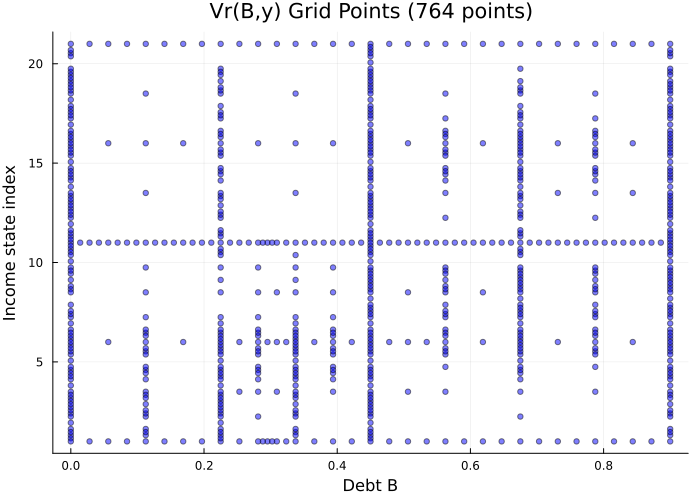

In [ ]:

# Run solver
fun_Vr, fun_Vd, q_matrix, prob_b_cache, Vr_cache, Vd_cache = solve_model_opt()

# ============================================================================ #
#                              VISUALIZATION                                   #
# ============================================================================ #

println("\n" * "="^70)
println("Generating plots...")
println("="^70)

# Compute policy functions and probabilities
Vf_matrix = zeros(nB, ny)
prob_d_matrix = zeros(nB, ny)
Bp_matrix = zeros(nB, ny)

for ib in 1:nB
    for iy in 1:ny
        # Envelope value
        _, probs = logsumexp_with_probs([Vr_cache[ib, iy], Vd_cache[iy]], INV_ETA_D)
        Vf_matrix[ib, iy] = max(Vr_cache[ib, iy], Vd_cache[iy])  # Approximation
        prob_d_matrix[ib, iy] = probs[2]

        # Optimal borrowing (expected value)
        Bp_matrix[ib, iy] = sum(prob_b_cache[:, ib, iy] .* B_grid)
    end
end

# Create plots
p1 = plot(B_grid, Bp_matrix, legend=false, title="Policy B'(B,y)",
          xlabel="Current debt B", ylabel="Next debt B'")
plot!(p1, B_grid, B_grid, linestyle=:dash, color=:black, linewidth=1, alpha=0.5)

p2 = plot(B_grid, prob_d_matrix*Pi', legend=false, title="Default Probability",
          xlabel="Debt B'", ylabel="Pr(default)")

p3 = plot(B_grid, q_matrix, legend=false, title="Bond Price q(B',y)",
          xlabel="Debt B'", ylabel="Price q")

p4 = plot(B_grid, Vf_matrix, legend=false, title="Value Function Vf(B,y)",
          xlabel="Debt B", ylabel="Value")

p_all = plot(p1, p2, p3, p4, layout=(2,2), size=(900, 700))

# savefig(p_all, "arellano_LT_ASG_optimized.png")

println("✓ Figure saved as 'arellano_LT_ASG_optimized.png'")

# Grid visualization
By_grid_final = extract_grid(fun_Vr)
p_grid = scatter(By_grid_final[:, 1], By_grid_final[:, 2],
                xlabel="Debt B", ylabel="Income state index",
                title="Vr(B,y) Grid Points ($(length(fun_Vr.nodes)) points)",
                markersize=3, alpha=0.5, legend=false,
                size=(700, 500), color=:blue)
# savefig(p_grid, "arellano_LT_ASG_optimized_grid.png")

println("✓ Grid plot saved as 'arellano_LT_ASG_optimized_grid.png'")
println("\n✓ Optimized model solved successfully!")
println("="^70 * "\n")
p_grid


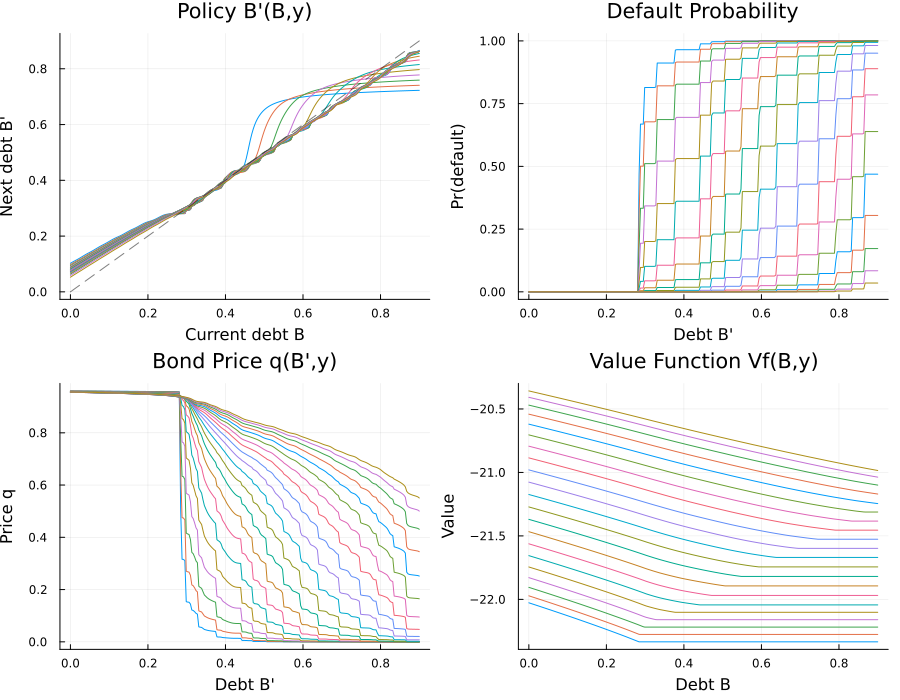

In [9]:
p_all